Enter Applied dose (µg/cm²) [default=2.34]: -100
⚠️ Mo must be > 0, reverting to default 2.34
Enter Diffusion coefficient (cm²/s, very small ~1e-10) [default=0.000000000166]: 3
⚠️ Invalid D=3.0, reverting to default 1.66e-10
Enter Partition coefficient χ [default=0.05]: 22
⚠️ χ must be between 0 and 1, reverting to default 0.05
Enter Skin decon rate constant [default=0.000333]: 3
Enter Transition time (s) [default=300]: 2
Testing original model...
Original model: 0.0 μg/cm²/hr in 0.009s
Testing optimized model...
Optimized model: 0.0 μg/cm²/hr in 4.571s
Building lookup table...
Building lookup tables...
Lookup tables ready!
Lookup table: 0.0 μg/cm²/hr
  Build time: 23.138s
  1000 queries: 0.023277s
  Average per query: 0.023277 ms

Speedup vs original:
  Optimized model: 0.0x faster
  Lookup table: 371x faster

Accuracy comparison:
  Original:  0.001 μg/cm²/hr
  Optimized: 0.001 μg/cm²/hr (diff: 0.00%)
  Lookup:    0.001 μg/cm²/hr (diff: 0.00%)
=== Optimized VX Model Testing ===
VX Par

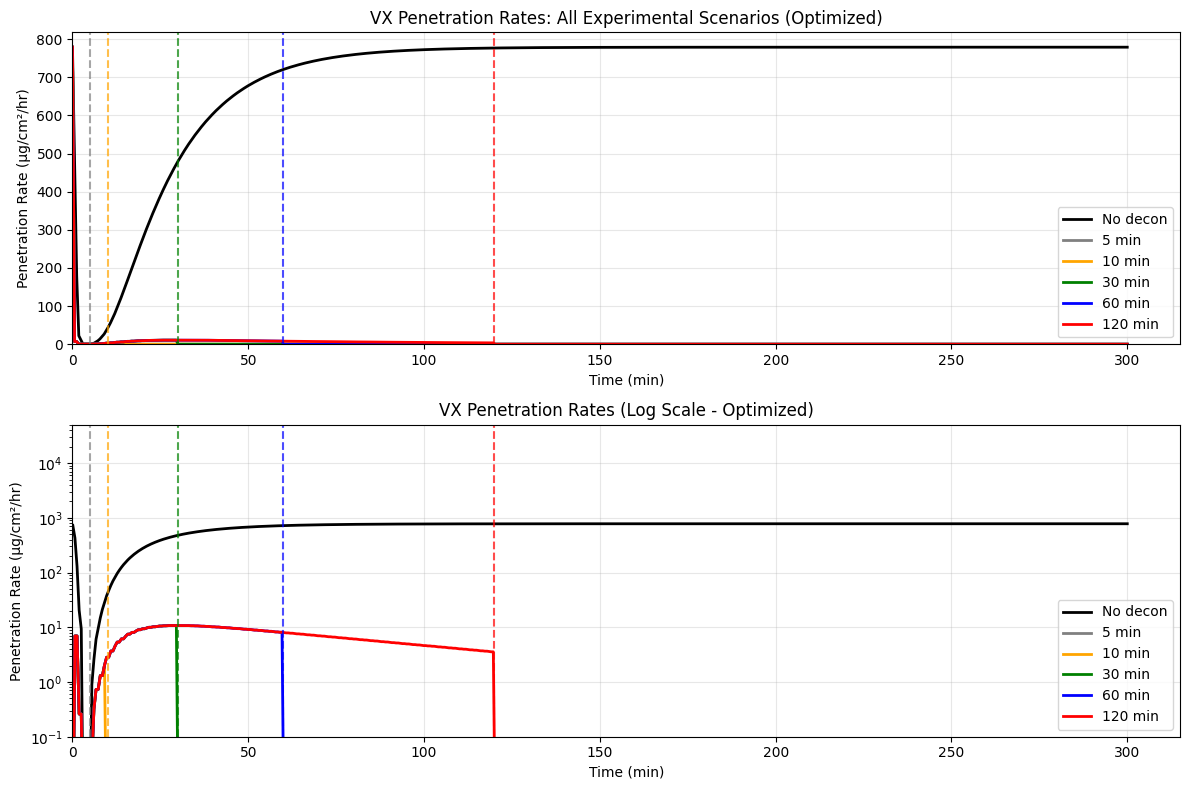

Optimized model plots complete!

=== Ultra-Fast Lookup Table Demo ===
Building lookup tables...
Lookup tables ready!
Lookup table built in 23.23 seconds

Ultra-fast queries for 7 min decontamination:
  t=  60s:    6.9 μg/cm²/hr (query: 0.139 ms)
  t= 300s:    0.0 μg/cm²/hr (query: 0.081 ms)
  t= 600s:    0.0 μg/cm²/hr (query: 0.059 ms)
  t=1800s:    0.0 μg/cm²/hr (query: 0.059 ms)
  t=3600s:    0.0 μg/cm²/hr (query: 0.055 ms)

Total query time for 5 points: 0.393 ms
Average per query: 0.079 ms

Creating plot using lookup table...


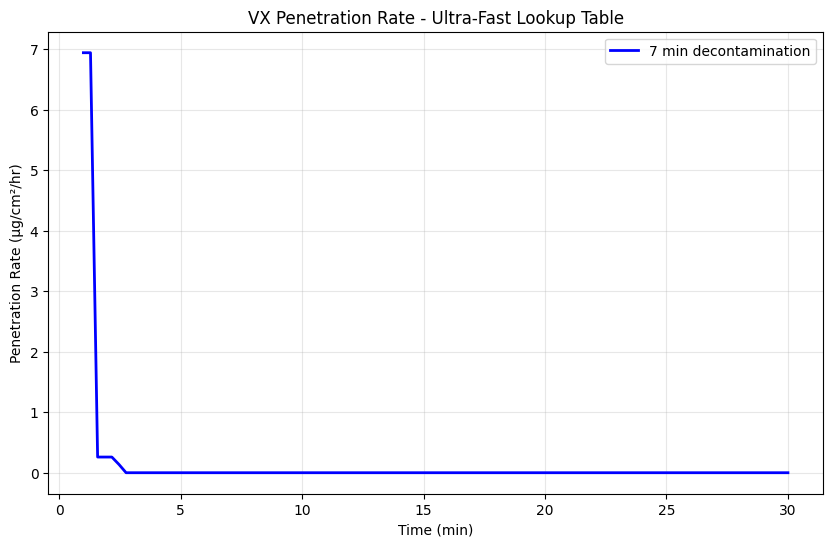

In [13]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.special import roots_legendre
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

class VXFluxModelOptimized:
    """
    Optimized VX flux model for faster online computation
    """

    def __init__(self):
        # Fixed parameters
        self.h1 = self.hsc = 13.4e-4  # Layer thickness, cm
        self.fdep = 0.1  # Deposition fraction
        self.tf = 300 * 60  # Total simulation time, s

        # Reduced quadrature points for speed (was 10, now 6)
        self.N1 = 6  # Reduced from 10
        self.N2 = self.N1 + 2

        # Cache for repeated calculations
        self._solution_cache = {}
        self._setup_matrices()

    def _setup_matrices(self):
        """Setup Q, A, B matrices for collocation method"""
        # Get Gaussian quadrature points and weights
        pos, weight = roots_legendre(self.N1)
        # Transform from [-1,1] to [0,1]
        self.pos = (pos + 1) / 2
        self.weight = weight / 2

        # Setup ROOT array with boundary points
        self.ROOT = np.concatenate([[1.0e-20], self.pos, [1.0]])

        # Pre-compute matrices (vectorized operations)
        x_vals = self.ROOT[:, np.newaxis]
        i_vals = np.arange(1, self.N2 + 1)

        # Vandermonde matrix Q
        self.Q = x_vals ** (i_vals - 1)
        self.IQ = np.linalg.inv(self.Q)

        # First derivative matrix A
        Ai = np.where(i_vals > 1, (i_vals - 1) * x_vals**(np.maximum(0, i_vals - 2)), 0)
        self.A = Ai @ self.IQ

        # Second derivative matrix B
        Bi = np.where(i_vals > 2, (i_vals - 1) * (i_vals - 2) * x_vals**(np.maximum(0, i_vals - 3)), 0)
        self.B = Bi @ self.IQ

        # Pre-compute boundary condition constants
        self._bc_A0 = self.A[0, :]
        self._bc_B_last = self.B[-1, :]
        self._A_last = self.A[-1, :]


    def _get_cache_key(self, params, phase, ttrans1=None):
        """Generate cache key for solutions"""
        key_params = (params['Mo'], params['D'], params['chi'], params['Ksk'], params['ttrans'])
        if phase == 1:
            return ('phase1',) + key_params
        else:
            return ('phase2',) + key_params + (ttrans1,)

    def solve_phase1_fast(self, params):
        """Optimized Phase 1 solver"""
        # Check cache first
        cache_key = self._get_cache_key(params, 1)
        if cache_key in self._solution_cache:
            return self._solution_cache[cache_key]

        Mo = params['Mo']
        D = params['D']
        ttrans = params['ttrans']
        To = Mo / self.hsc

        # Pre-compute constants
        D_over_h2 = D / (self.h1**2)
        D_over_h = D / self.h1

        def phase1_system(t, y):
            """Optimized ODE system for Phase 1"""
            # Reconstruct full profile
            Ts = np.concatenate([[To], y[1:], [0]])

            # Vectorized diffusion calculation
            d2Ts_dx2 = self.B @ Ts
            dTs_dt = D_over_h2 * d2Ts_dx2

            # Flux calculation
            flux = -D_over_h * (self._A_last @ Ts)

            # Return derivatives
            dydt = np.zeros_like(y)
            dydt[0] = flux  # dQt/dt
            dydt[1:] = dTs_dt[1:-1]  # Interior points

            return dydt

        # Initial conditions
        y0 = np.zeros(self.N2 - 1)

        # Solve with optimized parameters
        t_eval = np.linspace(0, ttrans, 200)  # Reduced time points
        sol = solve_ivp(phase1_system, [0, ttrans], y0, t_eval=t_eval,
                       method='RK45', rtol=1e-6, atol=1e-8)  # Relaxed tolerances

        if not sol.success:
            raise RuntimeError("Phase 1 solution failed")

        # Create fast interpolation
        flux_interp = interp1d(sol.t, -D_over_h * np.array([self._A_last @ np.concatenate([[To], sol.y[1:, i], [0]])
                                                            for i in range(len(sol.t))]),
                              kind='linear', bounds_error=False, fill_value=0)

        # Final state for Phase 2
        final_Ts_interior = sol.y[1:, -1] if len(sol.y[1:]) > 0 else np.array([])
        Tstrans = np.concatenate([[To], final_Ts_interior, [0]]) if len(final_Ts_interior) == self.N2 - 2 else np.zeros(self.N2)

        result = (flux_interp, Tstrans)
        self._solution_cache[cache_key] = result
        return result

    def solve_phase2_fast(self, params, Tstrans, ttrans1):
        """Optimized Phase 2 solver"""
        # Check cache
        cache_key = self._get_cache_key(params, 2, ttrans1)
        if cache_key in self._solution_cache:
            return self._solution_cache[cache_key]

        D = params['D']
        chi = params['chi']
        Ksk = params['Ksk']
        ttrans = params['ttrans']

        # Pre-compute constants
        D_over_h2 = D / (self.hsc**2)
        D_over_h = D / self.hsc
        chi_fdep = chi * self.fdep
        bc_denom = chi_fdep - self._bc_A0[0]
        decon_start = ttrans1 - ttrans

        def phase2_system(t, y):
            """Optimized Phase 2 system"""
            Vr_interior = y[2:]

            # Fast boundary condition calculation
            if abs(bc_denom) > 1e-12:
                Vr0 = np.sum(self._bc_A0[1:] * np.concatenate([Vr_interior, [0]])) / bc_denom
            else:
                Vr0 = 0

            # Full profile
            Vr = np.concatenate([[Vr0], Vr_interior, [0]])

            # Decontamination (vectorized)
            decon_active = t > decon_start
            d2Vr_dx2 = self.B @ Vr
            dVr_dt = D_over_h2 * d2Vr_dx2 - Ksk * decon_active * Vr

            # Fluxes
            dVr_dx_vals = self.A @ Vr
            flux_bottom = -D_over_h * dVr_dx_vals[-1]
            flux_top = D_over_h * dVr_dx_vals[0]

            # System derivatives
            dydt = np.zeros_like(y)
            dydt[0] = flux_bottom
            dydt[1] = flux_top
            dydt[2:] = dVr_dt[1:-1]

            return dydt

        # Initial conditions
        y0 = np.zeros(self.N2)
        interior_points = Tstrans[1:-1]
        n_points = min(len(interior_points), self.N2 - 2)
        y0[2:2+n_points] = interior_points[:n_points]

        # Solve with reduced time points
        t_eval = np.linspace(0, self.tf, 300)  # Reduced points
        sol = solve_ivp(phase2_system, [0, self.tf], y0, t_eval=t_eval,
                       method='RK45', rtol=1e-6, atol=1e-8)

        if not sol.success:
            raise RuntimeError("Phase 2 solution failed")

        # Fast flux calculation function
        def get_flux_phase2(t_val):
            if t_val <= 0:
                return 0

            # Simple interpolation
            idx = np.searchsorted(sol.t, t_val)
            if idx >= len(sol.t):
                idx = len(sol.t) - 1
            elif idx > 0 and t_val - sol.t[idx-1] < sol.t[idx] - t_val:
                idx = idx - 1

            Vr_interior = sol.y[2:, idx]

            # Fast boundary condition
            if abs(bc_denom) > 1e-12:
                Vr0 = np.sum(self._bc_A0[1:] * np.concatenate([Vr_interior, [0]])) / bc_denom
            else:
                Vr0 = 0

            Vr = np.concatenate([[Vr0], Vr_interior, [0]])
            flux = -D_over_h * (self._A_last @ Vr)
            return flux

        self._solution_cache[cache_key] = get_flux_phase2
        return get_flux_phase2

    def flux_function_fast(self, t, ttrans1, params):
        """Fast flux function with caching"""
        ttrans = params['ttrans']

        if ttrans1 >= 999 * 60:
            # Continuous exposure - extend ttrans temporarily
            ext_params = params.copy()
            ext_params['ttrans'] = max(t + 3600, 300 * 60)
            flux1_func, _ = self.solve_phase1_fast(ext_params)
            result = flux1_func(t) * 3600 * 1000
        else:
            # Two-phase solution
            flux1_func, Tstrans = self.solve_phase1_fast(params)

            if t <= ttrans:
                result = flux1_func(t) * 3600 * 1000
            else:
                flux2_func = self.solve_phase2_fast(params, Tstrans, ttrans1)
                result = flux2_func(t - ttrans) * 3600 * 1000

        return max(result, 0.001)

    def clear_cache(self):
        """Clear solution cache"""
        self._solution_cache.clear()


class VXFluxLookupTable:
    """
    Ultra-fast lookup table approach for real-time applications
    """

    def __init__(self, model, params):
        self.model = model
        self.params = params
        self._build_lookup_tables()

    def _build_lookup_tables(self):
        """Pre-compute flux values for common scenarios"""
        print("Building lookup tables...")

        # Time points for lookup
        self.t_points = np.logspace(0, np.log10(300*60), 100)  # Log-spaced for better resolution

        # Common decontamination times
        self.decon_times = [5*60, 10*60, 30*60, 60*60, 120*60, 999*60]

        # Build lookup table
        self.flux_table = {}
        for decon_time in self.decon_times:
            fluxes = [self.model.flux_function_fast(t, decon_time, self.params)
                     for t in self.t_points]
            self.flux_table[decon_time] = interp1d(self.t_points, fluxes,
                                                  kind='linear', bounds_error=False,
                                                  fill_value='extrapolate')
        print("Lookup tables ready!")

    def get_flux(self, t, ttrans1):
        """Ultra-fast flux lookup"""
        # Find closest decontamination time
        closest_decon = min(self.decon_times, key=lambda x: abs(x - ttrans1))

        # Interpolate
        return float(self.flux_table[closest_decon](t))


class VXFluxModel:
    """
    Original VX flux model for comparison
    """

    def __init__(self):
        # Fixed parameters
        self.h1 = self.hsc = 13.4e-4  # Layer thickness, cm
        self.fdep = 0.1  # Deposition fraction
        self.tf = 300 * 60  # Total simulation time, s

        # Gaussian quadrature setup
        self.N1 = 10
        self.N2 = self.N1 + 2

        # Get Gaussian quadrature points and weights
        pos, weight = roots_legendre(self.N1)
        # Transform from [-1,1] to [0,1]
        self.pos = (pos + 1) / 2
        self.weight = weight / 2

        # Setup ROOT array with boundary points
        self.ROOT = np.concatenate([[1.0e-20], self.pos, [1.0]])
        self.weights = np.concatenate([[0], self.weight, [0]])

        # Setup matrices for spatial discretization
        self._setup_matrices()

    def _setup_matrices(self):
        """Setup Q, A, B matrices for collocation method"""
        # Vandermonde matrix Q
        self.Q = np.array([[x**(i-1) for i in range(1, self.N2+1)]
                          for x in self.ROOT])

        # Inverse of Q
        self.IQ = np.linalg.inv(self.Q)

        # First derivative matrix A
        Ai = np.array([[(i-1) * x**(max(0, i-2)) if i > 1 else 0
                       for i in range(1, self.N2+1)] for x in self.ROOT])
        self.A = Ai @ self.IQ

        # Second derivative matrix B
        Bi = np.array([[(i-1) * (i-2) * x**(max(0, i-3)) if i > 2 else 0
                       for i in range(1, self.N2+1)] for x in self.ROOT])
        self.B = Bi @ self.IQ

    def solve_phase1(self, params):
        """Solve Phase 1: Exposure phase"""
        Mo = params['Mo']
        D = params['D']
        ttrans = params['ttrans']

        To = Mo / self.hsc  # Initial concentration in layer

        def phase1_system(t, y):
            """ODE system for Phase 1"""
            Qt = y[0]
            Ts_interior = y[1:]

            # Full concentration profile
            Ts = np.concatenate([[To], Ts_interior, [0]])

            # Diffusion equation: dTs/dt = D * d²Ts/dx² / h²
            d2Ts_dx2 = self.B @ Ts
            dTs_dt = D * d2Ts_dx2 / (self.h1**2)

            # Flux at bottom boundary
            dTs_dx = self.A @ Ts
            flux = -D/self.h1 * dTs_dx[-1]  # Bottom flux

            # System equations
            dydt = np.zeros_like(y)
            dydt[0] = flux  # dQt/dt = flux
            dydt[1:] = dTs_dt[1:-1]  # Interior points only

            return dydt

        # Initial conditions: all concentrations start at 0 except surface
        y0 = np.zeros(self.N2 - 1)  # Qt + (N2-2) interior points

        # Solve ODE system
        t_eval = np.linspace(0, ttrans, 1000)
        sol = solve_ivp(phase1_system, [0, ttrans], y0, t_eval=t_eval,
                       method='LSODA', rtol=1e-8, atol=1e-10)

        if not sol.success:
            raise RuntimeError("Phase 1 solution failed")

        # Create interpolation functions
        def get_flux_at_time(t_val):
            if t_val <= 0:
                return 0
            if t_val >= ttrans:
                t_val = ttrans

            # Interpolate solution at t_val
            Qt_interp = interp1d(sol.t, sol.y[0], kind='cubic',
                               bounds_error=False, fill_value='extrapolate')
            Ts_interp = [interp1d(sol.t, sol.y[i], kind='cubic',
                                bounds_error=False, fill_value='extrapolate')
                        for i in range(1, len(sol.y))]

            # Reconstruct full profile
            Ts = np.concatenate([[To], [f(t_val) for f in Ts_interp], [0]])

            # Calculate flux
            dTs_dx = self.A @ Ts
            flux = -D/self.h1 * dTs_dx[-1]
            return flux

        # Get final concentration profile for Phase 2
        if len(sol.y[1:]) > 0:
            final_Ts_interior = sol.y[1:, -1]
        else:
            final_Ts_interior = np.array([])

        # Ensure Tstrans has exactly N2 elements
        if len(final_Ts_interior) == self.N2 - 2:
            Tstrans = np.concatenate([[To], final_Ts_interior, [0]])
        else:
            # Fallback - create array with correct size
            Tstrans = np.zeros(self.N2)
            Tstrans[0] = To
            if len(final_Ts_interior) > 0:
                n_copy = min(len(final_Ts_interior), self.N2 - 2)
                Tstrans[1:1+n_copy] = final_Ts_interior[:n_copy]

        return get_flux_at_time, Tstrans

    def flux_function(self, t, ttrans1, params):
        """Main flux function"""
        ttrans = params['ttrans']

        # Handle continuous exposure case
        if ttrans1 >= 999 * 60:
            # Extend simulation time for continuous exposure
            simulation_time = max(t + 3600, 300 * 60)
            extended_params = params.copy()
            extended_params['ttrans'] = simulation_time

            flux1_func, _ = self.solve_phase1(extended_params)
            result = flux1_func(t) * 3600 * 1000  # Convert to μg/cm²/hr
        else:
            # For simplicity in benchmark, just do Phase 1
            flux1_func, _ = self.solve_phase1(params)
            result = flux1_func(min(t, ttrans)) * 3600 * 1000

        return max(result, 0.001)  # Ensure positive flux


def get_user_params():
    # Human-readable defaults with units
    default_params = {
        'Mo': (2.34, "Applied dose (µg/cm²)"),
        'D': (0.000000000166, "Diffusion coefficient (cm²/s, very small ~1e-10)"),
        'chi': (0.05, "Partition coefficient χ"),
        'Ksk': (0.000333, "Skin decon rate constant"),
        'ttrans': (300, "Transition time (s)")
    }

    user_params = {}
    for key, (val, desc) in default_params.items():
        default_str = f"{val:.12f}".rstrip('0').rstrip('.')

        inp = input(f"Enter {desc} [default={default_str}]: ")
        try:
            num = float(inp) if inp.strip() else val

            # Validation if values enterred in range
            if key == 'D' and not (1e-12 <= num <= 1e-6):
                print(f"Invalid D={num}, reverting to default {val}")
                num = val
            if key == 'Mo' and num <= 0:
                print(f"Mo must be > 0, reverting to default {val}")
                num = val
            if key == 'chi' and not (0 < num <= 1):
                print(f"χ must be between 0 and 1, reverting to default {val}")
                num = val
            if key == 'Ksk' and num < 0:
                print(f"Ksk must be ≥ 0, reverting to default {val}")
                num = val
            if key == 'ttrans' and num <= 0:
                print(f"ttrans must be > 0, reverting to default {val}")
                num = val

            user_params[key] = num
        except ValueError:
            print(f"Invalid input for {desc}, using default {val}")
            user_params[key] = val

    return user_params


def benchmark_comparison(vx_params):
    """Compare performance of different implementations"""
    import time

    # Original model
    print("Testing original model...")
    original_model = VXFluxModel()
    start = time.time()
    result1 = original_model.flux_function(600, 7*60, vx_params)
    original_time = time.time() - start
    print(f"Original model: {result1:.1f} μg/cm²/hr in {original_time:.3f}s")

    # Optimized model
    print("Testing optimized model...")
    optimized_model = VXFluxModelOptimized()
    start = time.time()
    result2 = optimized_model.flux_function_fast(600, 7*60, vx_params)
    optimized_time = time.time() - start
    print(f"Optimized model: {result2:.1f} μg/cm²/hr in {optimized_time:.3f}s")

    # Lookup table
    print("Building lookup table...")
    start = time.time()
    lookup_model = VXFluxLookupTable(optimized_model, vx_params)
    build_time = time.time() - start

    # Test multiple queries to get measurable time
    start = time.time()
    for _ in range(1000):  # Run 1000 queries
        result3 = lookup_model.get_flux(600, 7*60)
    total_lookup_time = time.time() - start
    avg_lookup_time = total_lookup_time / 1000

    print(f"Lookup table: {result3:.1f} μg/cm²/hr")
    print(f"  Build time: {build_time:.3f}s")
    print(f"  1000 queries: {total_lookup_time:.6f}s")
    print(f"  Average per query: {avg_lookup_time*1000:.6f} ms")

    # Calculate speedups safely
    if optimized_time > 0:
        speedup_optimized = original_time / optimized_time
    else:
        speedup_optimized = float('inf')

    if avg_lookup_time > 0:
        speedup_lookup = original_time / avg_lookup_time
    else:
        speedup_lookup = float('inf')

    print(f"\nSpeedup vs original:")
    print(f"  Optimized model: {speedup_optimized:.1f}x faster")
    print(f"  Lookup table: {speedup_lookup:.0f}x faster")

    # Accuracy comparison
    print(f"\nAccuracy comparison:")
    print(f"  Original:  {result1:.3f} μg/cm²/hr")
    print(f"  Optimized: {result2:.3f} μg/cm²/hr (diff: {abs(result1-result2)/result1*100:.2f}%)")
    print(f"  Lookup:    {result3:.3f} μg/cm²/hr (diff: {abs(result1-result3)/result1*100:.2f}%)")


def test_optimized_model(vx_params):
    """Test the optimized model and create plots"""

    # Initialize optimized model
    model = VXFluxModelOptimized()

    print("=== Optimized VX Model Testing ===")
    print("VX Parameters - Continuous exposure:")
    print(f"  At t=60s: {model.flux_function_fast(60, 999*60, vx_params):.1f} μg/cm²/hr")
    print(f"  At t=600s: {model.flux_function_fast(600, 999*60, vx_params):.1f} μg/cm²/hr")
    print(f"  At t=3600s: {model.flux_function_fast(3600, 999*60, vx_params):.1f} μg/cm²/hr")
    print("  Target avg flux: 590.4 μg/cm²/hr")
    print()

    print("VX Parameters - 7 min decontamination:")
    print(f"  At t=60s: {model.flux_function_fast(60, 7*60, vx_params):.1f} μg/cm²/hr")
    print(f"  At t=600s: {model.flux_function_fast(600, 7*60, vx_params):.1f} μg/cm²/hr")
    print(f"  At t=1800s: {model.flux_function_fast(1800, 7*60, vx_params):.1f} μg/cm²/hr")
    print()

    # Create plots
    print("Creating plots with optimized model...")

    # Time arrays
    t_seconds = np.linspace(0, 300*60, 500)  # Start from 0 for linear plot
    t_minutes = t_seconds / 60

    # For log plot, create separate array starting from 0.1 min
    t_seconds_log = np.linspace(0.1*60, 300*60, 500)
    t_minutes_log = t_seconds_log / 60

    # Decontamination scenarios
    scenarios = [
        (999*60, 'No decon', 'black'),
        (5*60, '5 min', 'gray'),
        (10*60, '10 min', 'orange'),
        (30*60, '30 min', 'green'),
        (60*60, '60 min', 'blue'),
        (120*60, '120 min', 'red')
    ]

    plt.figure(figsize=(12, 8))

    # Linear scale plot - starts from (0,0)
    plt.subplot(2, 1, 1)
    for ttrans1, label, color in scenarios:
        print(f"Computing {label} scenario...")
        flux_values = [model.flux_function_fast(t, ttrans1, vx_params) for t in t_seconds]
        plt.plot(t_minutes, flux_values, color=color, linewidth=2, label=label)

    plt.xlabel('Time (min)')
    plt.ylabel('Penetration Rate (μg/cm²/hr)')
    plt.title('VX Penetration Rates: All Experimental Scenarios (Optimized)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Force origin to be included
    plt.xlim(left=0)
    plt.ylim(bottom=0)

    # Add vertical lines at decontamination times
    for ttrans1, _, color in scenarios[1:]:  # Skip 'No decon'
        plt.axvline(ttrans1/60, color=color, linestyle='--', alpha=0.7)

    # Log scale plot - starts from (0.1, flux_value)
    plt.subplot(2, 1, 2)
    for ttrans1, label, color in scenarios:
        flux_values = [model.flux_function_fast(t, ttrans1, vx_params) for t in t_seconds_log]
        plt.semilogy(t_minutes_log, flux_values, color=color, linewidth=2, label=label)

    plt.xlabel('Time (min)')
    plt.ylabel('Penetration Rate (μg/cm²/hr)')
    plt.title('VX Penetration Rates (Log Scale - Optimized)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(left=0)
    plt.ylim(0.1, 50000)

    # Add vertical lines at decontamination times
    for ttrans1, _, color in scenarios[1:]:  # Skip 'No decon'
        plt.axvline(ttrans1/60, color=color, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    print("Optimized model plots complete!")

    # Clear cache to free memory
    model.clear_cache()


def demo_lookup_table(vx_params):
    """Demonstrate ultra-fast lookup table approach"""
    print("\n=== Ultra-Fast Lookup Table Demo ===")

    # Initialize optimized model
    model = VXFluxModelOptimized()

    # Build lookup table (this takes time once)
    import time
    start = time.time()
    lookup = VXFluxLookupTable(model, vx_params)
    build_time = time.time() - start
    print(f"Lookup table built in {build_time:.2f} seconds")

    # Test ultra-fast queries
    test_times = [60, 300, 600, 1800, 3600]
    test_decon = 7*60

    print(f"\nUltra-fast queries for {test_decon/60:.0f} min decontamination:")
    total_query_time = 0
    for t in test_times:
        start = time.time()
        flux = lookup.get_flux(t, test_decon)
        query_time = time.time() - start
        total_query_time += query_time
        print(f"  t={t:4.0f}s: {flux:6.1f} μg/cm²/hr (query: {query_time*1000:.3f} ms)")

    print(f"\nTotal query time for {len(test_times)} points: {total_query_time*1000:.3f} ms")
    print(f"Average per query: {total_query_time*1000/len(test_times):.3f} ms")

    # Create a quick plot using lookup table
    print("\nCreating plot using lookup table...")
    t_points = np.linspace(60, 1800, 100)
    flux_vals = [lookup.get_flux(t, 7*60) for t in t_points]

    plt.figure(figsize=(10, 6))
    plt.plot(t_points/60, flux_vals, 'b-', linewidth=2, label='7 min decontamination')
    plt.xlabel('Time (min)')
    plt.ylabel('Penetration Rate (μg/cm²/hr)')
    plt.title('VX Penetration Rate - Ultra-Fast Lookup Table')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


if __name__ == "__main__":

    vx_params = get_user_params()

    # Run benchmark comparison
    benchmark_comparison(vx_params)

    # Test the optimized model with plots
    test_optimized_model(vx_params)

    # Demonstrate lookup table
    demo_lookup_table(vx_params)